In [1]:
import os

import contextily as ctx
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from matplotlib import cm
import networkx as nx
from joblib import Parallel, delayed

In [2]:
enriched_points = dd.read_csv(
    "./anglova_metrics_enriched/points_enriched_metrics.csv",
).compute()
enriched_points["t"] = pd.to_datetime(enriched_points["t"])
enriched_trajectories_df = pd.read_csv(
    "./anglova_metrics_enriched/trajectories_enriched_metrics.csv",
)
pair_wise_distances = dd.read_csv(
    "./pairwise_distances.csv",
).compute()


In [3]:
output_path = "./assets/Leader Following Patterns/"

In [4]:
def save_plot(filename):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(
        f"{output_path}/{filename}.png",
        bbox_inches="tight",
    )
    plt.savefig(
        f"{output_path}/{filename}.pdf",
        bbox_inches="tight",
    )

In [5]:
cud_okabe_ito_colors = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # reddish orange
    "#CC79A7",  # purple
    "#000000",  # black
]

In [6]:
def get_company_color(company):
    if company == 6:
        return sns.color_palette("Set2")[company - 1 % len(sns.color_palette("Set2"))]
    return sns.color_palette("Set1")[company - 1 % len(sns.color_palette("Set1"))]

### Time-lagged correlation

In [7]:
from scipy.stats import pearsonr

def compute_time_lagged_correlation(enriched_points, time_lag):
    results = []
    grouped = enriched_points.groupby(['id1', 'id2'])
    
    for (id1, id2), group in grouped:
        group = group.sort_values('t')  # Ensure data is sorted by time
        distances = group[['x', 'y']].values
        
        if len(distances) > time_lag:
            lagged_distances = distances[:-time_lag]
            current_distances = distances[time_lag:]
            
            # Compute Pearson correlation
            correlation, _ = pearsonr(lagged_distances, current_distances)
            results.append({'id1': id1, 'id2': id2, 'correlation': correlation})
    
    return pd.DataFrame(results)

# Example usage with a time lag of 1
time_lag = 1
time_lagged_correlation_df = compute_time_lagged_correlation(enriched_points, time_lag)
print(time_lagged_correlation_df)

       id1  id2  correlation
0        1    2     0.999976
1        1    3     0.999981
2        1    4     0.999987
3        1    5     0.999986
4        1    6     0.999986
...    ...  ...          ...
12241  154  156     0.999726
12242  154  157     0.998748
12243  155  156     0.998987
12244  155  157     0.999858
12245  156  157     0.999933

[12246 rows x 3 columns]


In [37]:
# Filter for Company 1
# Recreate merged_df if not already defined
merged_df = time_lagged_correlation_df.merge(
    enriched_trajectories_df[['trajectory_id', 'Company']],
    left_on='id2',
    right_on='trajectory_id',
    how='left'
)

# Filter for Company 1 and Platoon 1
company_1_platoon_1_data = merged_df.merge(
    enriched_trajectories_df[['trajectory_id', 'Platoon']],
    left_on='id2',
    right_on='trajectory_id',
    how='left'
)
company_1_platoon_1_data = company_1_platoon_1_data[
    (company_1_platoon_1_data['Company'] == 1) & (company_1_platoon_1_data['Platoon'] == 1)
]

# Compute the average correlation for each id1
average_correlation_company_1_platoon_1 = company_1_platoon_1_data.groupby('id1')['correlation'].mean().reset_index()
average_correlation_company_1_platoon_1.rename(columns={'correlation': 'average_correlation'}, inplace=True)


In [38]:
# Merge average_correlation_company_1 with enriched_trajectories_df to include the Command column
merged_with_command = average_correlation_company_1_platoon_1.merge(
    enriched_trajectories_df[['trajectory_id', 'Command']],
    left_on='id1',
    right_on='trajectory_id',
    how='left'
)

# Group by Command and calculate the mean average correlation
command_avg_correlation = merged_with_command.groupby('Command')['average_correlation'].mean().reset_index()

# Sort by average correlation in descending order
command_avg_correlation = command_avg_correlation.sort_values(by='average_correlation', ascending=False)

print(command_avg_correlation)

                    Command  average_correlation
0         Company Commander             0.999987
1  Deputy Company Commander             0.999986
2                   Unknown             0.999896


C:\Users\edgar\AppData\Local\Temp\ipykernel_18132\376269127.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


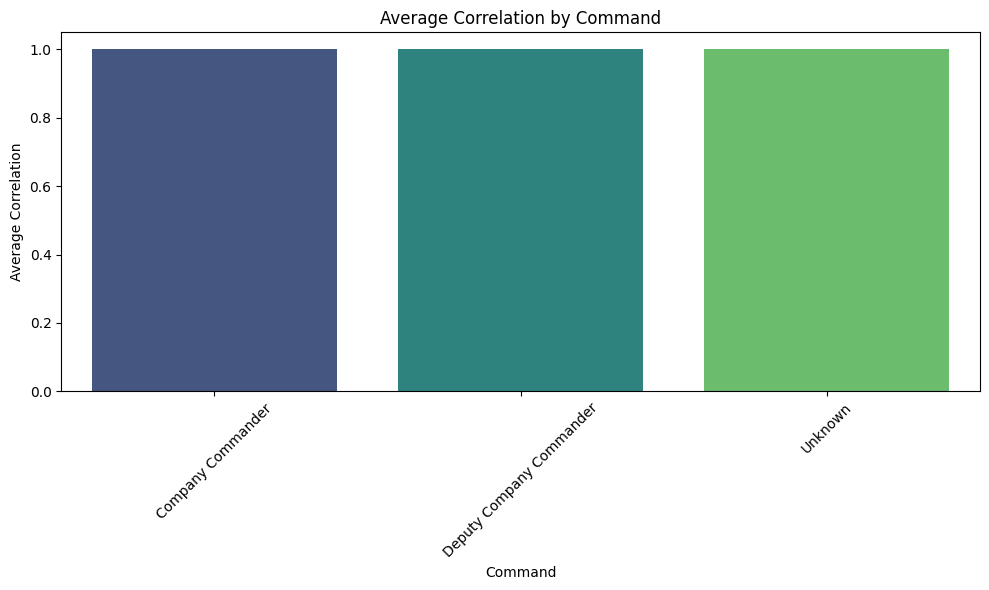

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=command_avg_correlation,
    x='Command',
    y='average_correlation',
    palette='viridis'
)
plt.title('Average Correlation by Command')
plt.xlabel('Command')
plt.ylabel('Average Correlation')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


### DTW (Dynamic Time Warping)

In [8]:
!pip install fastdtw

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3635 sha256=4ee8c109bf86fd6b7be8e58d1b1c224890d3e4f9eed802046932f9a03669b53d
  Stored in directory: c:\users\edgar\appdata\local\pip\cache\wheels\73\c8\f7\c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def find_leading_following_pairs(pair_wise_filtered):
    results = []
    for _, row in pair_wise_filtered.iterrows():
        id1_trajectory = enriched_points[enriched_points['trajectory_id'] == row['id1']].sort_values('t')[['x', 'y']].values
        id2_trajectory = enriched_points[enriched_points['trajectory_id'] == row['id2']].sort_values('t')[['x', 'y']].values
        
        if len(id1_trajectory) > 0 and len(id2_trajectory) > 0:
            # Compute DTW distance
            distance, _ = fastdtw(id1_trajectory, id2_trajectory, dist=euclidean)
            results.append({'id1': row['id1'], 'id2': row['id2'], 'dtw_distance': distance})
    
    return pd.DataFrame(results)

# Example usage
pair_wise_filtered = pair_wise_distances[
    (pair_wise_distances['id1'].isin(enriched_trajectories_df[enriched_trajectories_df['Company'] == 1]['trajectory_id'])) &
    (pair_wise_distances['id2'].isin(enriched_trajectories_df[enriched_trajectories_df['Company'] == 1]['trajectory_id']))
]
dtw_results = find_leading_following_pairs(pair_wise_filtered)
print(dtw_results)

### Graph Approach

In [24]:
import itertools

FOLLOW_THRESHOLD = 0.2

def compute_leader_graph(enriched_trajectories_df, pair_wise_distances, company=None):
    if company is not None:
        filtered_trajectories = enriched_trajectories_df[enriched_trajectories_df['Company'] == company]
    else:
        filtered_trajectories = enriched_trajectories_df

    trajectory_ids = filtered_trajectories['trajectory_id'].unique()

    all_pairs = pd.DataFrame(
        [(id1, id2) for id1, id2 in itertools.product(trajectory_ids, trajectory_ids) if id1 != id2],
        columns=['id1', 'id2']
    )

    pair_wise_distances_full = all_pairs.merge(
        pair_wise_distances,
        on=['id1', 'id2'],
        how='left'
    )

    pair_wise_distances_full['follow'] = pair_wise_distances_full['distance'].notna().astype(int)

    total_counts = pair_wise_distances_full.groupby('id2').size().reset_index(name='total')
    follow_counts = pair_wise_distances_full.groupby(['id1', 'id2'])['follow'].sum().reset_index(name='count')

    follow_df = follow_counts.merge(total_counts, on='id2')
    follow_df['follow_fraction'] = follow_df['count'] / follow_df['total']

    consistent_follows = follow_df[follow_df['follow_fraction'] > FOLLOW_THRESHOLD]

    G = nx.DiGraph()
    for _, row in consistent_follows.iterrows():
        G.add_edge(row['id1'], row['id2'], weight=row['follow_fraction'])

    pagerank_scores = nx.pagerank(G, weight='weight')

    pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=['trajectory_id', 'pagerank'])
    pagerank_df = pagerank_df.merge(enriched_trajectories_df, on='trajectory_id', how='left')
    pagerank_df = pagerank_df.sort_values('pagerank', ascending=False)
    return pagerank_df


In [25]:
def plot_top_leaders_bar(pagerank_df, top_n=10, title="Top Leaders by PageRank", filename=None):
    """
    Plota um gráfico de barras com os top_n líderes pelo PageRank.
    Se filename for fornecido, salva a imagem em PNG e PDF.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    top_leaders = pagerank_df.head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_leaders,
        x="pagerank",
        y="trajectory_id",
        hue="Company" if "Company" in top_leaders.columns else None,
        dodge=False,
        palette="Set1"
    )
    plt.xlabel("PageRank")
    plt.ylabel("Trajectory ID")
    plt.title(title)
    plt.legend(title="Company", loc="lower right")
    plt.tight_layout()
    if filename:
        plt.savefig(f"{output_path}/{filename}.png", bbox_inches="tight")
        plt.savefig(f"{output_path}/{filename}.pdf", bbox_inches="tight")
    plt.show()

# Exemplo de uso para o geral:
# plot_top_leaders_bar(pagerank_df_geral, top_n=10, title="Top 10 Líderes (Geral)", filename="top10_leaders_geral")

Geral:
   trajectory_id  pagerank                   Command  Company  Platoon
4            5.0  0.381654                   Unknown        1        1
3            4.0  0.223608                   Unknown        1        1
2            3.0  0.166507                   Unknown        1        1
1            2.0  0.133350  Deputy Company Commander        1        1
0            1.0  0.094881         Company Commander        1        1


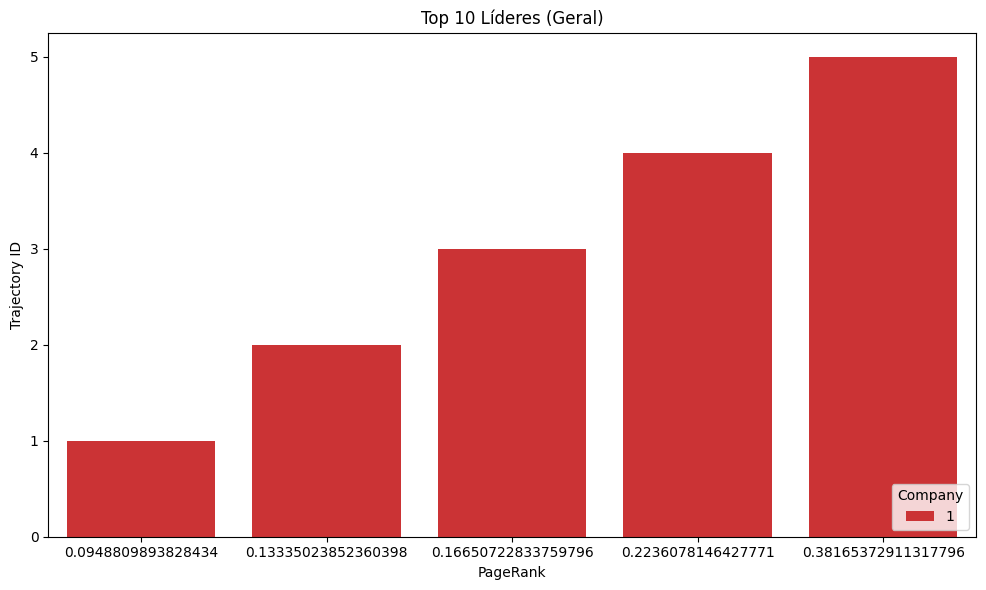

In [26]:
# Geral
print("Geral:")
pagerank_df_geral = compute_leader_graph(enriched_trajectories_df, pair_wise_distances)
print(pagerank_df_geral[['trajectory_id', 'pagerank', 'Command', 'Company', 'Platoon']].head(10))
plot_top_leaders_bar(pagerank_df_geral, top_n=10, title="Top 10 Líderes (Geral)", filename="top10_leaders_geral")

In [20]:

# Por Company
for company in enriched_trajectories_df['Company'].unique():
    print(f"\nCompany {company}:")
    pagerank_df_company = compute_leader_graph(enriched_trajectories_df, pair_wise_distances, company=company)
    print(pagerank_df_company[['trajectory_id', 'pagerank', 'Command', 'Company', 'Platoon']].head(10))


Company 1:
   trajectory_id  pagerank                   Command  Company  Platoon
1            2.0  0.649123  Deputy Company Commander        1        1
0            1.0  0.350877         Company Commander        1        1

Company 2:
   trajectory_id  pagerank                   Command  Company  Platoon
1           26.0  0.649123  Deputy Company Commander        2        1
0           25.0  0.350877         Company Commander        2        1

Company 3:
   trajectory_id  pagerank                   Command  Company  Platoon
1           50.0  0.649123  Deputy Company Commander        3        1
0           49.0  0.350877         Company Commander        3        1

Company 4:
   trajectory_id  pagerank                   Command  Company  Platoon
1           74.0  0.649123  Deputy Company Commander        4        1
0           73.0  0.350877         Company Commander        4        1

Company 5:
   trajectory_id  pagerank                     Command  Company  Platoon
1           98.

### Velocity and heading consistency

In [31]:
import numpy as np
import pandas as pd

def analyze_leadership(enriched_points, distance_std_thresh=5, heading_mean_thresh=15):
    ids = enriched_points['trajectory_id'].unique()
    results = []
    for id1 in ids:
        for id2 in ids:
            if id1 == id2:
                continue
            # Alinhar pontos no tempo
            traj1 = enriched_points[enriched_points['trajectory_id'] == id1][['t', 'x', 'y', 'direction']].sort_values('t')
            traj2 = enriched_points[enriched_points['trajectory_id'] == id2][['t', 'x', 'y', 'direction']].sort_values('t')
            merged = pd.merge(traj1, traj2, on='t', suffixes=('_1', '_2'))
            if len(merged) < 5:
                continue
            # Distância ao longo do tempo
            # Usar pair_wise_distances para pegar a distância já calculada
            # Tentar merge com id1/id2 e, se não houver resultado, inverter id1/id2
            merged_dist = pd.merge(
                merged,
                pair_wise_distances,
                left_on=['t', 'trajectory_id_1', 'trajectory_id_2'],
                right_on=['t', 'id1', 'id2'],
                how='left'
            )
            if merged_dist['distance'].isnull().all():
                # Tenta inverter id1/id2
                merged_dist = pd.merge(
                    merged,
                    pair_wise_distances,
                    left_on=['t', 'trajectory_id_2', 'trajectory_id_1'],
                    right_on=['t', 'id1', 'id2'],
                    how='left'
                )
            dist = merged_dist['distance']
            dist_std = dist.std()
            # Diferença de direção
            heading_diff = (merged['direction_1'] - merged['direction_2']).abs()
            heading_diff = heading_diff.apply(lambda x: min(x, 360 - x))
            heading_mean = heading_diff.mean()
            # Critério de seguimento
            if dist_std < distance_std_thresh and heading_mean < heading_mean_thresh:
                results.append({'leader': id1, 'follower': id2})
    # Contar seguidores por líder
    df = pd.DataFrame(results)
    leader_counts = df.groupby('leader').size().reset_index(name='n_followers')
    leader_counts = leader_counts.sort_values('n_followers', ascending=False)
    return leader_counts

leader_counts = analyze_leadership(enriched_points)
print(leader_counts.head())

KeyError: 'trajectory_id_1'